# Pesticide Prediction

In [1]:
import logging
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from rapidfuzz import process
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from src.config import conf
from src.constants import TORCH_DEVICE
from src.dataloaders import load_graph
from src.models import HGT

if any("Arial" in f.name for f in fm.fontManager.ttflist):
    plt.rcParams["font.family"] = "Arial"
_logger = logging.getLogger(__name__)

## Load KG and Model

Read CSV of nodes and edges.

In [2]:
nodes = pd.read_csv(conf.paths.kg.nodes_path, dtype={"node_index": int}, low_memory=False)
edges = pd.read_csv(
    conf.paths.kg.edges_path, dtype={"edge_index": int, "x_index": int, "y_index": int}, low_memory=False
)
embeddings = torch.load(conf.paths.checkpoint.embeddings_path)
_logger.info(f"Number of nodes: {len(nodes)}")
_logger.info(f"Number of edges: {len(edges) / 2:.0f}")

PD_pesticide_edges = edges[(edges['relation'] == 'exposure_disease') & (edges['x_name'] == 'Parkinson disease')]
PD_pesticides = PD_pesticide_edges['y_name'].unique().tolist()
_logger.info(f"Number of known PD pesticides: {len(PD_pesticides)}")

[12/09/25 23:21:48] INFO     Number of nodes: 147020                                                ]8;id=335747;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py\2722281576.py]8;;\:]8;id=758130;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py#6\6]8;;\

                    INFO     Number of edges: 7366745                                               ]8;id=693732;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py\2722281576.py]8;;\:]8;id=749562;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py#7\7]8;;\

[12/09/25 23:21:49] INFO     Number of known PD pesticides: 41                                     ]8;id=834818;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py\2722281576.py]8;;\:]8;id=187209;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2722281576.py#11\11]8;;\

In [3]:
pl.seed_everything(conf.seed, workers=True)
kg = load_graph(nodes, edges)
pretrain_model = HGT.load_from_checkpoint(
    checkpoint_path=str(conf.paths.checkpoint.checkpoint_path),
    kg=kg,
    strict=False,
)
pretrain_model.eval()
pretrain_model = pretrain_model.to(TORCH_DEVICE)

# Make output directory
os.makedirs(conf.paths.notebooks.pesticide_prediction_dir, exist_ok=True)

Seed set to 42


## Read Gene Sets

Read full set of protein coding genes downloaded from the [Human Gene Nomenclature Committee](https://www.genenames.org/cgi-bin/download/custom?col=gd_hgnc_id&col=gd_app_sym&col=gd_app_name&col=gd_status&col=gd_prev_sym&col=gd_aliases&col=gd_pub_chrom_map&col=gd_pub_acc_ids&col=gd_pub_refseq_ids&col=gd_locus_type&col=gd_locus_group&col=gd_prev_name&col=gd_name_aliases&col=gd_date2app_or_res&col=gd_date_mod&col=gd_date_sym_change&col=gd_date_name_change&col=gd_enz_ids&col=gd_pub_eg_id&col=gd_pub_ensembl_id&col=gd_mgd_id&col=gd_other_ids&col=gd_other_ids_list&col=gd_pubmed_ids&col=family.id&col=family.name&col=gd_ccds_ids&col=gd_vega_ids&col=gd_lsdb_links&status=Approved&status=Entry%20Withdrawn&hgnc_dbtag=on&order_by=gd_app_sym_sort&format=text&submit=submit).

In [4]:
hgnc = pd.read_csv(conf.paths.mappings.hgnc_path, sep="\t", low_memory=False)
protein_coding_genes = hgnc[hgnc["Locus group"] == "protein-coding gene"]

full_gene_nodes = nodes[nodes["node_type"] == "gene/protein"].copy()
gene_nodes = full_gene_nodes[full_gene_nodes["node_name"].isin(protein_coding_genes["Approved symbol"])]
_logger.info(f"Number of total genes: {len(full_gene_nodes)}")
_logger.info(f"Number of protein-coding genes: {len(gene_nodes)}")

gene_indices = gene_nodes["node_index"].values
gene_embeddings = embeddings[gene_indices]
_logger.info(f"Gene embeddings shape: {gene_embeddings.shape}")

exposure_nodes = nodes[nodes["node_type"] == "exposure"].copy()
_logger.info("Number of exposures: %s", len(exposure_nodes))

[12/09/25 23:22:03] INFO     Number of total genes: 35198                                           ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py\3226202904.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py#6\6]8;;\

                    INFO     Number of protein-coding genes: 19179                                  ]8;id=571858;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py\3226202904.py]8;;\:]8;id=91161;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py#7\7]8;;\

                    INFO     Gene embeddings shape: torch.Size([19179, 512])                       ]8;id=229258;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py\3226202904.py]8;;\:]8;id=243962;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py#11\11]8;;\

                    INFO     Number of exposures: 860                                              ]8;id=750800;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py\3226202904.py]8;;\:]8;id=681453;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/3226202904.py#14\14]8;;\

Read in pesticide sets from Excel file.

In [5]:
pesticide_file = pd.ExcelFile(conf.paths.notebooks.pesticide_lists)

# Load the gene sets
query_sets = {
    "PWAS_candidates": list(pd.read_excel(pesticide_file, "ALLfromSuppTable2")["Common Name"].values),
    "PWAS_hits": list(pd.read_excel(pesticide_file, "PWAS_hits")["Common Name"].values),
    "PWAS_DA_hits": list(pd.read_excel(pesticide_file, "ten_Daneuron_Hits")["Common Name"].values),
}

## Map Pesticides to Nodes

Map pesticides to exposure nodes in NeuroKG using fuzzy matching.

In [6]:
pesticide_lists = ["PWAS_candidates", "PWAS_hits", "PWAS_DA_hits"]
pesticide_fuzzy_match = {}

# Iterate over pesticide lists
for pesticide_list_name in pesticide_lists:
    pesticide_set = query_sets[pesticide_list_name]

    # For each pesticide, fuzzy match to exposure nodes
    matched_pesticides = []

    for pesticide in pesticide_set:
        # Perform fuzzy matching
        matches = process.extract(pesticide, exposure_nodes["node_name"].values, limit=1, score_cutoff=80)

        # If there is a match, add to list
        if len(matches) > 0:
            best_match = matches[0][0]
            match_score = matches[0][1]
            matched_pesticides.append((pesticide, best_match, match_score))
        else:
            matched_pesticides.append((pesticide, None, None))

    # Create table of matches
    fuzzy_match_table = pd.DataFrame(matched_pesticides, columns=["Pesticide", "Match", "Score"])
    pesticide_fuzzy_match[pesticide_list_name] = fuzzy_match_table
    pesticide_matches = fuzzy_match_table[fuzzy_match_table["Match"].notnull()]["Match"].values
    _logger.info(f"{pesticide_list_name}: {len(pesticide_set)} pesticides --> {len(pesticide_matches)} matches --> {len(pesticide_set)} unique nodes")

    # Update pesticide set
    pesticide_set = list(set(pesticide_matches))
    query_sets[pesticide_list_name] = pesticide_set

[12/09/25 23:22:04] INFO     PWAS_candidates: 288 pesticides --> 140 matches --> 288 unique nodes  ]8;id=291704;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py\2706280232.py]8;;\:]8;id=848749;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py#27\27]8;;\

                    INFO     PWAS_hits: 68 pesticides --> 41 matches --> 68 unique nodes           ]8;id=167414;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py\2706280232.py]8;;\:]8;id=732052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py#27\27]8;;\

                    INFO     PWAS_DA_hits: 10 pesticides --> 6 matches --> 10 unique nodes         ]8;id=225772;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py\2706280232.py]8;;\:]8;id=800581;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2706280232.py#27\27]8;;\

## Principal Component Analysis

                    INFO     PCA1:   31.92%                                                        ]8;id=888662;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=360663;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

                    INFO     PCA2:   20.83%                                                        ]8;id=765179;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=481741;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

                    INFO     PCA3:   9.75%                                                         ]8;id=82627;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=578856;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

                    INFO     PCA4:   7.37%                                                         ]8;id=928463;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=903565;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

                    INFO     PCA5:   6.24%                                                         ]8;id=72933;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=48050;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

                    INFO     PCA6:   4.49%                                                         ]8;id=83667;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py\1984767675.py]8;;\:]8;id=896865;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1984767675.py#37\37]8;;\

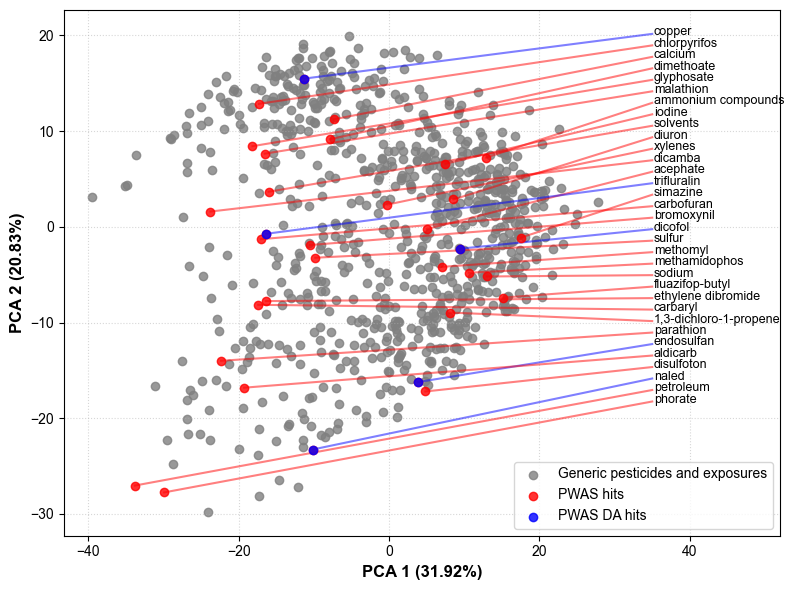

In [7]:
# Add column to exposure nodes if PWAS candidate
exposure_nodes["PWAS_candidate"] = 0
exposure_nodes.loc[exposure_nodes["node_name"].isin(query_sets["PWAS_candidates"]), "PWAS_candidate"] = 1

# Add column to exposure nodes if PWAS hit
exposure_nodes["PWAS_hit"] = 0
exposure_nodes.loc[exposure_nodes["node_name"].isin(query_sets["PWAS_hits"]), "PWAS_hit"] = 1

# Add column to exposure nodes if PWAS DA hit
exposure_nodes["PWAS_DA_hit"] = 0
exposure_nodes.loc[exposure_nodes["node_name"].isin(query_sets["PWAS_DA_hits"]), "PWAS_DA_hit"] = 1

# Add column to exposure nodes if known PD pesticide
exposure_nodes['PD_pesticide'] = 0
exposure_nodes.loc[exposure_nodes['node_name'].isin(PD_pesticides), 'PD_pesticide'] = 1

# Get embeddings of exposure nodes
exposure_indices = exposure_nodes["node_index"].values
exposure_embeddings = embeddings[exposure_indices]

# Scale embeddings
scaler = StandardScaler()
exposure_embeddings = scaler.fit_transform(exposure_embeddings)

# Run PCA on exposure embeddings
pca = PCA(n_components=10, random_state=conf.seed)
pca.fit(exposure_embeddings)
exposure_pca = pca.transform(exposure_embeddings)

# Get embeddings and add first k PCs
num_PCs = 6
var_explained = pca.explained_variance_ratio_
for i in range(num_PCs):
    exposure_nodes[f"PCA{i + 1}"] = exposure_pca[:, i]

    # Print explained variance
    _logger.info(f"PCA{i + 1}:\t{var_explained[i] * 100:.2f}%")

# Plot PCA
plt.figure(figsize=(8, 6))

# Plot nodes that are not PWAS hits
non_pwas_hits = exposure_nodes[(exposure_nodes["PWAS_hit"] == 0) & (exposure_nodes["PWAS_DA_hit"] == 0)]
plt.scatter(
    non_pwas_hits["PCA1"],
    non_pwas_hits["PCA2"],
    color="gray",
    label="Generic pesticides and exposures",
    alpha=0.8,
    zorder=1,
)

# Make color of PWAS hits red
pwas_hits = exposure_nodes[exposure_nodes["PWAS_hit"] == 1]
plt.scatter(pwas_hits["PCA1"], pwas_hits["PCA2"], color="red", label="PWAS hits", alpha=0.8, zorder=3)

# Make color of PWAS DA hits blue
pwas_da_hits = exposure_nodes[exposure_nodes["PWAS_DA_hit"] == 1]
plt.scatter(pwas_da_hits["PCA1"], pwas_da_hits["PCA2"], color="blue", label="PWAS DA hits", alpha=0.8, zorder=4)

# Create axis titles
plt.xlabel(f"PCA 1 ({var_explained[0] * 100:.2f}%)", fontsize=12, fontweight="bold")
plt.ylabel(f"PCA 2 ({var_explained[1] * 100:.2f}%)", fontsize=12, fontweight="bold")

plt.grid(True, linestyle=":", alpha=0.5, zorder=0)
plt.legend()
plt.tight_layout()

plt.savefig(conf.paths.notebooks.pesticide_prediction_dir / "exposure_pca.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.pesticide_prediction_dir / "exposure_pca.svg", bbox_inches="tight")

# Plot labels on right side of graph in a line, and draw lines
nodes_to_plot = exposure_nodes[exposure_nodes["PWAS_hit"] == 1].copy()
nodes_to_plot["node_name"] = nodes_to_plot["node_name"].str.lower()
nodes_to_plot = nodes_to_plot.sort_values(by="PCA2", ascending=False)
nodes_to_plot.reset_index(inplace=True)
for i, row in nodes_to_plot.iterrows():
    coord_x = 35
    coord_y = 20 - 1.2 * i
    plt.text(coord_x + 0.2, coord_y, row["node_name"], fontsize=9, zorder=5)
    if row["PWAS_DA_hit"] == 1:
        plt.plot([row["PCA1"], coord_x], [row["PCA2"], coord_y + 0.15], color="blue", alpha=0.5, zorder=2)
    elif row["PWAS_hit"] == 1:
        plt.plot([row["PCA1"], coord_x], [row["PCA2"], coord_y + 0.15], color="red", alpha=0.5, zorder=2)

# Expand right x limit
plt.xlim(plt.xlim()[0], 52)

# Save plot
plt.savefig(conf.paths.notebooks.pesticide_prediction_dir / "exposure_pca_labels.pdf", bbox_inches="tight")
plt.savefig(conf.paths.notebooks.pesticide_prediction_dir / "exposure_pca_labels.svg", bbox_inches="tight")

In [8]:
# Set seed
pl.seed_everything(42, workers=True)

# Create label column
exposure_ft = exposure_nodes.copy()
exposure_nodes["label"] = 0
exposure_nodes["split"] = "none"

# Create positive training set (PWAS_hit == 1 and PWAS_DA_hit == 0) OR (PD_pesticide == 1)
training_set_pos = exposure_ft[(exposure_ft['PWAS_hit'] == 1) & (exposure_ft['PWAS_DA_hit'] == 0)].index
exposure_ft.loc[training_set_pos, 'label'] = 1
exposure_ft.loc[training_set_pos, 'split'] = 'train'

# Create negative training set (PWAS_hit == 0 and PWAS_DA_hit == 0 and PD_pesticide == 0, sample 100)
training_set_neg = exposure_ft[(exposure_ft['PWAS_hit'] == 0) & (exposure_ft['PWAS_DA_hit'] == 0) & (exposure_ft['PD_pesticide'] == 0)]
training_set_neg = training_set_neg.sample(100).index
exposure_ft.loc[training_set_neg, 'label'] = 0
exposure_ft.loc[training_set_neg, 'split'] = 'train'

# Create positive test set (PWAS_hit == 1 and PWAS_DA_hit == 1 and PD_pesticide == 0)
test_set_pos = exposure_ft[(exposure_ft['PWAS_hit'] == 1) & (exposure_ft['PWAS_DA_hit'] == 1) & (exposure_ft['PD_pesticide'] == 0)].index
exposure_ft.loc[test_set_pos, 'label'] = 1
exposure_ft.loc[test_set_pos, 'split'] = 'test'

# Create negative test set (PWAS_hit == 0 and PWAS_DA_hit == 0 and PD_pesticide == 0, sample 10)
test_set_neg = exposure_ft[(exposure_ft['PWAS_hit'] == 0) & (exposure_ft['PWAS_DA_hit'] == 0) & (exposure_ft['PD_pesticide'] == 0) & (exposure_ft['split'] != 'train')]
test_set_neg = test_set_neg.sample(10).index
exposure_ft.loc[test_set_neg, 'label'] = 0
exposure_ft.loc[test_set_neg, 'split'] = 'test'

# Print summary of label/split combinations
_logger.info(exposure_ft[['label', 'split']].value_counts())

_logger.info("Summary of label/split combinations:")
_logger.info(f"Number of exposure nodes: {len(exposure_ft)}")
_logger.info(f"Number of training set positive: {len(training_set_pos)}")
_logger.info(f"Number of training set negative: {len(training_set_neg)}")
_logger.info(f"Number of test set positive: {len(test_set_pos)}")
_logger.info(f"Number of test set negative: {len(test_set_neg)}")

Seed set to 42


[12/09/25 23:22:05] INFO     label  split                                                          ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#32\32]8;;\
                             0.0    train    100                                                                   
                             1.0    train     28                                                                   
                             0.0    test      10                                                                   
                             1.0    test       4                                                                   
                             Name: count, dtype: int64                                                             

                    INFO     Summary of label/split combinations:                                  ]8;id=571858;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=91161;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#34\34]8;;\

                    INFO     Number of exposure nodes: 860                                         ]8;id=229258;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=243962;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#35\35]8;;\

                    INFO     Number of training set positive: 28                                   ]8;id=750800;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=681453;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#36\36]8;;\

                    INFO     Number of training set negative: 100                                  ]8;id=617889;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=291704;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#37\37]8;;\

                    INFO     Number of test set positive: 4                                        ]8;id=167414;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=732052;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#38\38]8;;\

                    INFO     Number of test set negative: 10                                       ]8;id=800581;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py\1879578297.py]8;;\:]8;id=352944;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/1879578297.py#39\39]8;;\

## Fine-tune PROTON

Create the pesticide prediction module and training data.

In [9]:
# Set seed
pl.seed_everything(42, workers = True)

# Define prediction module
class PesticidePredictionModule(nn.Module):

    def __init__(self):
        super(PesticidePredictionModule, self).__init__()

        self.fc1 = nn.Linear(num_PCs, 4)
        self.fc2 = nn.Linear(4, 1)
        # self.fc1 = nn.Linear(4, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        # x = torch.sigmoid(F.relu(self.fc1(x)))
        return x

# Instantiate model
classifier = PesticidePredictionModule().to(TORCH_DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr = 0.001)
n_epochs = 400
batch_size = 8

# Create training set
train_data = exposure_ft[exposure_ft['split'] == 'train']
test_data = exposure_ft[exposure_ft['split'] == 'test']
PC_cols = [f'PCA{i + 1}' for i in range(num_PCs)]

train_X = train_data[PC_cols].values
train_y = train_data['label'].values

test_X = test_data[PC_cols].values
test_y = test_data['label'].values

train_dataset = TensorDataset(torch.tensor(train_X, dtype = torch.float32), torch.tensor(train_y, dtype = torch.float32))
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

test_dataset = TensorDataset(torch.tensor(test_X, dtype = torch.float32), torch.tensor(test_y, dtype = torch.float32))
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

exposure_X = exposure_ft[PC_cols].values
exposure_y = exposure_ft['label'].values

full_dataset = TensorDataset(torch.tensor(exposure_X, dtype = torch.float32), torch.tensor(exposure_y, dtype = torch.float32))
full_loader = DataLoader(full_dataset, batch_size = batch_size, shuffle = False)

Seed set to 42


Fine-tune PROTON by training the pesticide prediction module.

In [10]:
# Train model
for epoch in range(n_epochs):
    
    classifier.train()
    train_loss = 0
    train_correct = 0

    for i, (X, y) in enumerate(train_loader):

        X, y = X.to(TORCH_DEVICE), y.to(TORCH_DEVICE)

        optimizer.zero_grad()
        y_pred = classifier(X).flatten()
        loss = criterion(y_pred, y)
        loss.backward()

        # Compute metrics
        train_loss += loss.item()
        train_correct += (y_pred.round() == y).sum().item()

        # Update weights
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    train_acc = train_correct / len(train_loader.dataset)

    # Evaluate model
    classifier.eval()
    test_loss = 0
    test_correct = 0

    with torch.no_grad():

        for i, (X, y) in enumerate(test_loader):

            X, y = X.to(TORCH_DEVICE), y.to(TORCH_DEVICE)

            y_pred = classifier(X).flatten()
            test_loss += criterion(y_pred, y).item()
            test_correct += (y_pred.round() == y).sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / len(test_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs}:\tTrain loss: {train_loss:.4f}\tTrain acc: {train_acc:.2f}\tTest loss: {test_loss:.4f}\tTest acc: {test_acc:.2f}")


# Save model
torch.save(classifier.state_dict(), conf.paths.notebooks.pesticide_prediction_dir / 'pesticide_prediction_module.pth')

Epoch 10/400:	Train loss: 0.0916	Train acc: 0.47	Test loss: 0.1094	Test acc: 0.50
Epoch 20/400:	Train loss: 0.0696	Train acc: 0.69	Test loss: 0.0835	Test acc: 0.64
Epoch 30/400:	Train loss: 0.0652	Train acc: 0.69	Test loss: 0.0789	Test acc: 0.64
Epoch 40/400:	Train loss: 0.0634	Train acc: 0.70	Test loss: 0.0773	Test acc: 0.64
Epoch 50/400:	Train loss: 0.0622	Train acc: 0.70	Test loss: 0.0770	Test acc: 0.64
Epoch 60/400:	Train loss: 0.0614	Train acc: 0.71	Test loss: 0.0773	Test acc: 0.64
Epoch 70/400:	Train loss: 0.0606	Train acc: 0.78	Test loss: 0.0777	Test acc: 0.71
Epoch 80/400:	Train loss: 0.0598	Train acc: 0.78	Test loss: 0.0776	Test acc: 0.71
Epoch 90/400:	Train loss: 0.0591	Train acc: 0.78	Test loss: 0.0778	Test acc: 0.71
Epoch 100/400:	Train loss: 0.0584	Train acc: 0.78	Test loss: 0.0773	Test acc: 0.71
Epoch 110/400:	Train loss: 0.0576	Train acc: 0.78	Test loss: 0.0778	Test acc: 0.71
Epoch 120/400:	Train loss: 0.0568	Train acc: 0.77	Test loss: 0.0786	Test acc: 0.71
Epoch 130/400

Generate predictions for all exposure nodes.

In [11]:
# Evaluate model
classifier.eval()

# Get predictions
predictions = []

with torch.no_grad():
    
        for i, (X, _) in enumerate(full_loader):
    
            X = X.to(TORCH_DEVICE)
    
            # Forward pass
            y_pred = classifier(X).flatten()
    
            predictions.append(y_pred)

predictions = torch.cat(predictions).cpu().numpy()

# Add predictions to exposure nodes
exposure_ft['prediction'] = predictions
pmin, pmax = predictions.min(), predictions.max()
den = (pmax - pmin) if (pmax > pmin) else 1.0
exposure_ft['scaled_pred'] = (predictions - pmin) / den
exposure_ft = exposure_ft.sort_values(by = 'prediction', ascending = False)

In [12]:
# Masks
mask_all      = exposure_ft['prediction'].notna()             # all exposure nodes with a prediction
mask_known    = exposure_ft['PD_pesticide'].eq(0)             # exclude known PD pesticides
mask_no_train = mask_known & exposure_ft['split'].ne('train') # exclude train as well

print("Number of exposure nodes (all):                         ", int(mask_all.sum()))
print("Number of nodes without known PD pesticides:           ", int(mask_known.sum()))
print("Number of nodes without known PD pesticides and not in training set: ",
      int(mask_no_train.sum()))

# Helper to add ranks & percentile ranks in-place
def add_rank_columns(df, mask, pred_col, rank_col, pr_col):
    n = int(mask.sum())
    if n == 0:
        df[rank_col] = pd.NA
        df[pr_col]   = pd.NA
        return
    ranks = df.loc[mask, pred_col].rank(ascending=False, method='min')
    df.loc[mask, rank_col] = ranks.astype(int)
    df.loc[mask, pr_col]   = 100.0 * ranks / n

# Compute all three rank variants
add_rank_columns(exposure_ft, mask_all,      'prediction', 'rank_all',       'per_rank_all')
add_rank_columns(exposure_ft, mask_known,    'prediction', 'rank_no_known',  'per_rank_no_known')
add_rank_columns(exposure_ft, mask_no_train, 'prediction', 'rank_no_train',  'per_rank_no_train')

# Print ground truth ranks
exposure_ft[exposure_ft['PWAS_DA_hit'] == 1].sort_values(by = 'rank_all', ascending = True)

Number of exposure nodes (all):                          860
Number of nodes without known PD pesticides:            819
Number of nodes without known PD pesticides and not in training set:  696


,node_index,node_id,node_type,node_name,node_source,node_type_index,PWAS_candidate,PWAS_hit,PWAS_DA_hit,PD_pesticide,...,label,split,prediction,scaled_pred,rank_all,per_rank_all,rank_no_known,per_rank_no_known,rank_no_train,per_rank_no_train
65837,65837,D004726,exposure,Endosulfan,CTD,354,1,1,1,0,...,1.0,test,0.695277,0.817921,10.0,1.162791,10.0,1.221001,9.0,1.293103
141162,141162,D004010,exposure,Dicofol,CTD,777,1,1,1,0,...,1.0,test,0.400993,0.471726,155.0,18.023256,141.0,17.216117,118.0,16.954023
65916,65916,D009267,exposure,Naled,CTD,433,1,1,1,0,...,1.0,test,0.399948,0.470498,157.0,18.255814,143.0,17.460317,119.0,17.097701
66001,66001,D014274,exposure,Trifluralin,CTD,518,1,1,1,1,...,NaN,NaN,0.382573,0.450058,168.0,19.534884,NaN,NaN,NaN,NaN
65542,65542,D003300,exposure,Copper,CTD,59,1,1,1,0,...,1.0,test,0.182886,0.215147,290.0,33.720930,268.0,32.722833,221.0,31.752874


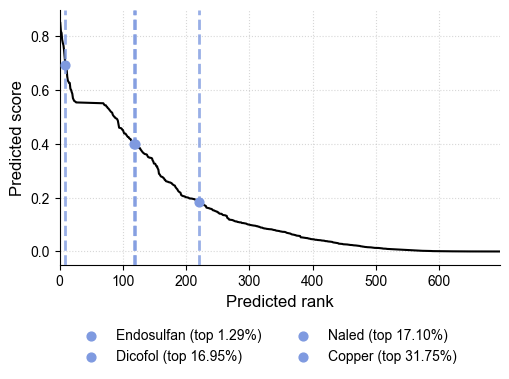

In [13]:
plot_df = exposure_ft.loc[mask_no_train].copy()
plot_df = plot_df.sort_values('rank_no_train')

fig, ax = plt.subplots(figsize=(5.2, 4))
ax.plot(plot_df['rank_no_train'].values,
        plot_df['prediction'].values,
        color='black', linewidth=1.5, zorder=2)

ax.set_xlabel('Predicted rank', fontsize=12)
ax.set_ylabel('Predicted score', fontsize=12)
ax.set_xlim(0, len(plot_df))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

min_score = plot_df['prediction'].min()
max_score = plot_df['prediction'].max()
ax.set_ylim(min_score - 0.05, max_score + 0.05)

# Ground truth (PWAS_DA_hit == 1) within no-train set
ground_truth = plot_df.loc[plot_df['PWAS_DA_hit'].eq(1)].sort_values('rank_no_train')

k = 0
for i, row in ground_truth.iterrows():
    node_name = row['node_name']
    node_color = "#7F9AE0"
    ax.axvline(x = row['rank_no_train'], color = node_color, linestyle = '--', alpha = 0.8, zorder = 3, linewidth = 2)
    if k > 10:
        ax.scatter(row['rank_no_train'], row['prediction'], color = node_color, zorder = 3)
    else:
        ground_truth_label = f"{node_name} (top {100*row['rank_no_train']/len(plot_df):.2f}%)"
        ax.scatter(row['rank_no_train'], row['prediction'], color = node_color, label=ground_truth_label, zorder = 3, s = 40)
    k += 1

ax.grid(True, linestyle=':', alpha=0.5, zorder=0)
ax.legend(loc='upper center', bbox_to_anchor=(0.47, -0.2), ncol=2, frameon=False, fontsize=10)
    
# Save plot
plt.tight_layout()
plt.savefig(conf.paths.notebooks.pesticide_prediction_dir  / 'PWAS_DA_hits.pdf', bbox_inches = 'tight')
plt.savefig(conf.paths.notebooks.pesticide_prediction_dir  / 'PWAS_DA_hits.svg', bbox_inches = 'tight')
# plt.close()

[12/09/25 23:22:37] INFO     Pesticide: Endosulfan (top 1.29%)                                     ]8;id=234053;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py\2440902886.py]8;;\:]8;id=146316;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py#49\49]8;;\

                    INFO     Pesticide: Dicofol (top 16.95%)                                       ]8;id=935518;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py\2440902886.py]8;;\:]8;id=571858;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py#49\49]8;;\

                    INFO     Pesticide: Naled (top 17.10%)                                         ]8;id=31244;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py\2440902886.py]8;;\:]8;id=98246;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py#49\49]8;;\

                    INFO     Pesticide: Copper (top 31.75%)                                        ]8;id=27824;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py\2440902886.py]8;;\:]8;id=588508;file:///var/folders/zn/zjsg_nfx11j1fcfm90jjtts40000gq/T/ipykernel_11923/2440902886.py#49\49]8;;\

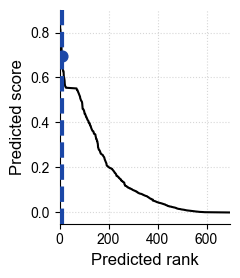

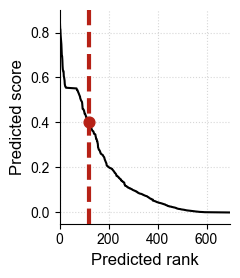

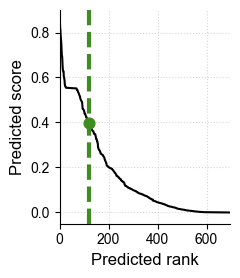

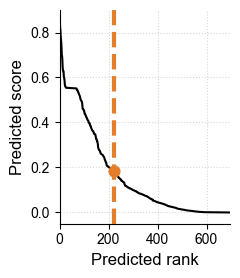

In [14]:
plot_df = exposure_ft.loc[mask_no_train].copy()
plot_df = plot_df.sort_values('rank_no_train')

# Make subdirectory
output_dir = conf.paths.notebooks.pesticide_prediction_dir / 'test_set'
output_dir.mkdir(parents=True, exist_ok=True)

# Define colors
# colors = ["#2A4D96", "#AA2C24", "#477A33", "#D2803C"]
colors = ["#1B47A7", "#B62116", "#3F8D20", "#E27E2C"]
ground_truth = plot_df.loc[plot_df['PWAS_DA_hit'].eq(1)].sort_values('rank_no_train')

# Plot each pesticide in test set
for i, (index, row) in enumerate(ground_truth.iterrows()):
    fig, ax = plt.subplots(figsize=(2.5, 2.88))

    ax.plot(plot_df['rank_no_train'].values,
            plot_df['prediction'].values,
            color='black', linewidth=1.5, zorder=2)
    
    ax.set_xlabel('Predicted rank', fontsize=12)
    ax.set_ylabel('Predicted score', fontsize=12)
    ax.set_xlim(0, len(plot_df))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    min_score = plot_df['prediction'].min()
    max_score = plot_df['prediction'].max()
    ax.set_ylim(min_score - 0.05, max_score + 0.05)

    # Plot line for specific pesticide
    node_name = row['node_name']
    node_color = colors[i % len(colors)]

    ax.axvline(x=row['rank_no_train'], color=node_color, linestyle='--', 
               alpha=1, zorder=3, linewidth=3)
    ground_truth_label = f"{node_name} (top {100 * row['rank_no_train'] / len(plot_df):.2f}%)"
    ax.scatter(row['rank_no_train'], row['prediction'], color=node_color, 
               label=ground_truth_label, zorder=3, s=60)

    ax.grid(True, linestyle=':', alpha=0.5, zorder=0)
    
    plt.tight_layout()

    # Save figure
    safe_name = node_name.lower().replace(" ", "_")
    plt.savefig(output_dir / f'{safe_name}.pdf', bbox_inches='tight')
    plt.savefig(output_dir / f'{safe_name}.svg', bbox_inches='tight')
    _logger.info(f"Pesticide: {ground_truth_label}")

In [15]:
col_map = {
    "node_index"       : "Node index",
    "node_name"        : "Pesticide",
    "prediction"       : "Score",
    "rank_all"         : "Rank (all)",
    "per_rank_all"     : "Percentile rank (all) (%)",
    "rank_no_known"    : "Rank (no-known)",
    "per_rank_no_known": "Percentile rank (no-known) (%)",
    "rank_no_train"    : "Rank (no-train)",
    "per_rank_no_train": "Percentile rank (no-train) (%)",
    "PWAS_candidate"   : "PWAS candidate",
    "PWAS_hit"         : "PWAS hit",
    "PWAS_DA_hit"      : "PWAS DA hit",
    "PD_pesticide"     : "PD pesticide",
    "label"            : "Label",
    "split"            : "Split",
}

wanted_cols = [c for c in col_map if c in exposure_ft.columns]
exposure_ft_xlsx = (
    exposure_ft[wanted_cols]
    .rename(columns=col_map)
)
df = exposure_ft_xlsx

xlsx_path = conf.paths.notebooks.pesticide_prediction_dir / "PD_pesticide_ranking.xlsx"
with pd.ExcelWriter(xlsx_path, engine="xlsxwriter") as writer:
    df.to_excel(writer, sheet_name="Ranking", startrow=1, index=False)

    wb = writer.book
    ws = writer.sheets["Ranking"]

    # Formats
    arial_fmt   = wb.add_format({"font_name": "Arial"})
    title_fmt   = wb.add_format({"bold": True, "font_size": 14,
                                 "align": "center", "valign": "vcenter",
                                 "font_name": "Arial"})
    header_fmt  = wb.add_format({"bold": True, "bg_color": "#D7E4BC",
                                 "border": 1, "valign": "top",
                                 "font_name": "Arial"})
    foot_fmt    = wb.add_format({"italic": True, "font_size": 8,
                                 "font_name": "Arial"})
    hilite_fmt  = wb.add_format({"bg_color": "#FFF2CC", "font_name": "Arial"})

    # Title
    last_col = len(df.columns) - 1
    last_letter = chr(ord("A") + last_col)
    ws.merge_range(f"A1:{last_letter}1",
                   "PROTON PD Pesticide Prediction",
                   title_fmt)

    # Header styling
    for i, col in enumerate(df.columns):
        ws.write(1, i, col, header_fmt)
        width = max(len(col), df[col].astype(str).str.len().max()) + 2
        ws.set_column(i, i, width, arial_fmt)
    ws.set_column(0, 0, 30, arial_fmt)
    ws.freeze_panes(2, 0)
    ws.autofilter(1, 0, len(df) + 1, last_col)
    first_data  = 3 
    last_data   = len(df) + 2

    # 3 color scale on Rank
    rank_idx = df.columns.get_loc("Rank (no-train)")
    ws.conditional_format(first_data-1, rank_idx,
                          last_data-1,  rank_idx,
                          {"type":      "3_color_scale",
                           "min_color": "#63BE7B",
                           "mid_color": "#FFEB84",
                           "max_color": "#F8696B"})
    
    # Color code split column
    train_fmt = wb.add_format({"bg_color": "#219ebc"})
    test_fmt = wb.add_format({"bg_color": "#fb8500"})

    split_idx = df.columns.get_loc("Split")
    split_col = chr(ord("A") + split_idx)
    ws.conditional_format(first_data-1, split_idx,
                          last_data-1, split_idx,
                          {"type":     "formula",
                           "criteria": f'=${split_col}{first_data}="train"',
                           "format":   train_fmt})
    ws.conditional_format(first_data-1, split_idx,
                          last_data-1, split_idx,
                          {"type":     "formula",
                           "criteria": f'=${split_col}{first_data}="test"',
                           "format":   test_fmt})
    
    # Highlight rows where Label == 1
    label_idx  = df.columns.get_loc("Label")
    label_col  = chr(ord("A") + label_idx)
    ws.conditional_format(first_data-1, 0,
                          last_data-1, last_col,
                          {"type":     "formula",
                           "criteria": f'=${label_col}{first_data}=1',
                           "format":   hilite_fmt})